In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

In [40]:
path = '../input/train'

**Importing data and overview**
- Will read the input files and merge with the training data
- Extract date features from date column

In [41]:
train = pd.read_csv(os.path.join(path,'2016-09-19_79351_training.csv'))
mcc_cats = pd.read_csv(os.path.join(path,'mcc_group_definition.csv'))
txn_types = pd.read_csv(os.path.join(path, 'transaction_types.csv'))

txn_types.rename(columns={'explanation':'txn_explanations'}, inplace=True)

train = train.merge(mcc_cats, on='mcc_group',how='left')

train = train.merge(txn_types, left_on='transaction_type', right_on='type', how='left')

train.drop(['type'],axis=1, inplace=True)

In [42]:
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
train['month'] = train['transaction_date'].apply(lambda x: x.month)
train['day_of_week'] = train['transaction_date'].apply(lambda x: x.day_of_week)
train['day_of_month'] = train['transaction_date'].apply(lambda x: x.day)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              408546 non-null  object        
 1   transaction_date     408546 non-null  datetime64[ns]
 2   transaction_type     408546 non-null  object        
 3   mcc_group            258324 non-null  float64       
 4   amount_n26_currency  408546 non-null  int64         
 5   dataset_transaction  408546 non-null  object        
 6   dataset_user         408546 non-null  object        
 7   explanation          258324 non-null  object        
 8   txn_explanations     408546 non-null  object        
 9   direction            408546 non-null  object        
 10  agent                408546 non-null  object        
 11  month                408546 non-null  int64         
 12  day_of_week          408546 non-null  int64         
 13  day_of_month  

In [44]:
train.shape

(408546, 14)

In [45]:
train['user_id'].nunique()

10000

In [46]:
train['direction'].unique()

array(['Out', 'In'], dtype=object)

In [47]:
train.tail()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,explanation,txn_explanations,direction,agent,month,day_of_week,day_of_month
408541,bc639c7495889105713fc6b1025264ac,2016-07-31,DT,NaN,5,training,training,NaN,Debit Transfer,Out,Bank Account,7,6,31
408542,0dfb685e3d705957ef9e0c472604b067,2016-07-31,DT,NaN,155,training,training,NaN,Debit Transfer,Out,Bank Account,7,6,31
408543,918eb93c2d3b084614e3570886715f84,2016-07-31,DT,NaN,19,training,training,NaN,Debit Transfer,Out,Bank Account,7,6,31
408544,918eb93c2d3b084614e3570886715f84,2016-07-31,DT,NaN,19,training,training,NaN,Debit Transfer,Out,Bank Account,7,6,31
408545,25afbb78936ce100bbd1e61cecb37403,2016-07-31,DT,NaN,36,training,training,NaN,Debit Transfer,Out,Bank Account,7,6,31


# Data Processing & Visualization

In [48]:
total = train.groupby(['month','direction'])['amount_n26_currency'].sum().reset_index()

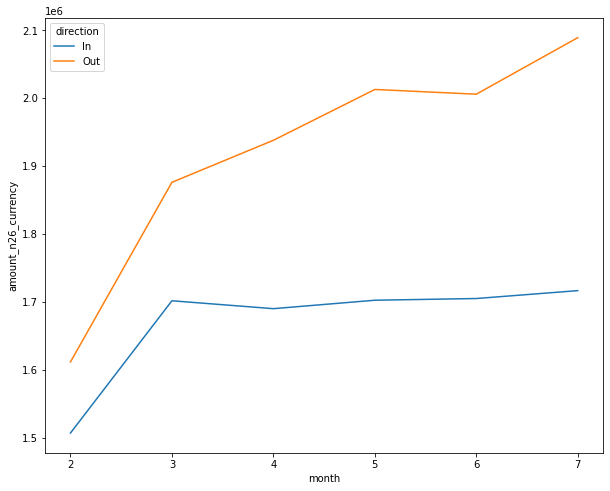

In [49]:
plt.figure(figsize=(10,8))
sns.lineplot(data=total, x='month',y='amount_n26_currency',hue='direction')
plt.show()

**gap widens between Income and expense as month progresses**

In [50]:
def plot_monthly_inflows_outflows():
    month = train.groupby(['direction','month'])['amount_n26_currency'].mean().reset_index()
    month['amount_n26_currency'] = month['amount_n26_currency'].astype('int')
    
    
    day_of_month = train.groupby(['direction','day_of_month'])['amount_n26_currency'].mean().reset_index()
    day_of_month['amount_n26_currency'] = day_of_month['amount_n26_currency'].astype('int')
    
    day_of_week = train.groupby(['direction','day_of_week'])['amount_n26_currency'].mean().reset_index()
    day_of_week['amount_n26_currency'] = day_of_week['amount_n26_currency'].astype('int')
    
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,12))
    
    sns.barplot(data=month, x='month',y='amount_n26_currency', hue='direction',ax=ax1)
    ax1.set_ylabel("Amount")
    
    sns.barplot(data=day_of_month, x='day_of_month',y='amount_n26_currency', hue='direction', ax=ax2)
    ax2.set_ylabel("Amount")
    
    sns.barplot(data=day_of_week, x='day_of_week',y='amount_n26_currency', hue='direction', ax=ax3)
    ax3.set_ylabel("Amount")
    
    plt.show()

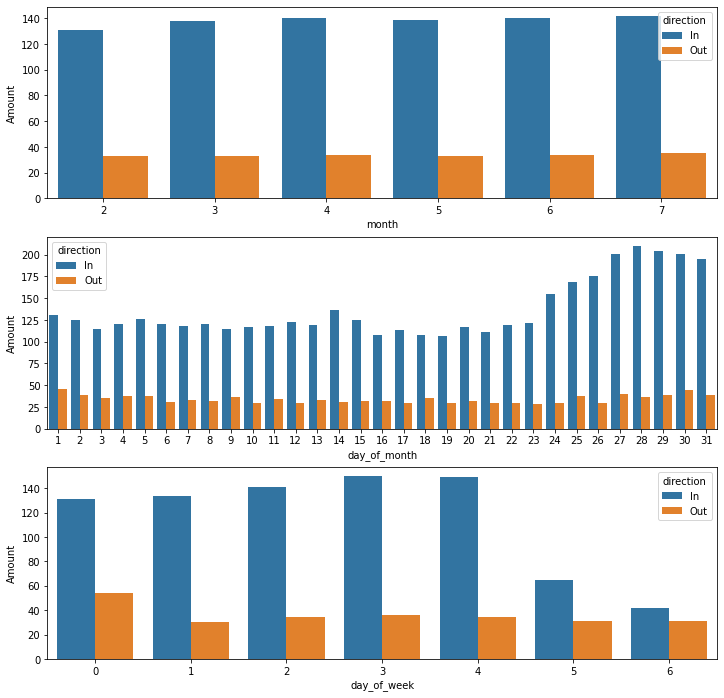

In [51]:
plot_monthly_inflows_outflows()

**plot the same graphs for a user to have better look**

In [52]:
def plot_monthly_inflows_outflows_user(user):
    month = train.query(f"user_id =='{user}'").groupby(['direction','month'])['amount_n26_currency'].mean().reset_index()
    month['amount_n26_currency'] = month['amount_n26_currency'].astype('int')
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,12))
    
    day_of_month = train.query(f"user_id =='{user}'").groupby(['direction','day_of_month'])['amount_n26_currency'].mean().reset_index()
    day_of_month['amount_n26_currency'] = day_of_month['amount_n26_currency'].astype('int')
    
    day_of_week = train.query(f"user_id =='{user}'").groupby(['direction','day_of_week'])['amount_n26_currency'].mean().reset_index()
    day_of_week['amount_n26_currency'] = day_of_week['amount_n26_currency'].astype('int')
    
    
    
    sns.barplot(data=month, x='month',y='amount_n26_currency', hue='direction',ax=ax1)
    ax1.set_ylabel("Amount")
    
    sns.barplot(data=day_of_month, x='day_of_month',y='amount_n26_currency', hue='direction', ax=ax2)
    ax2.set_ylabel("Amount")
    
    sns.barplot(data=day_of_week, x='day_of_week',y='amount_n26_currency', hue='direction', ax=ax3)
    ax3.set_ylabel("Amount")
    
    plt.show()

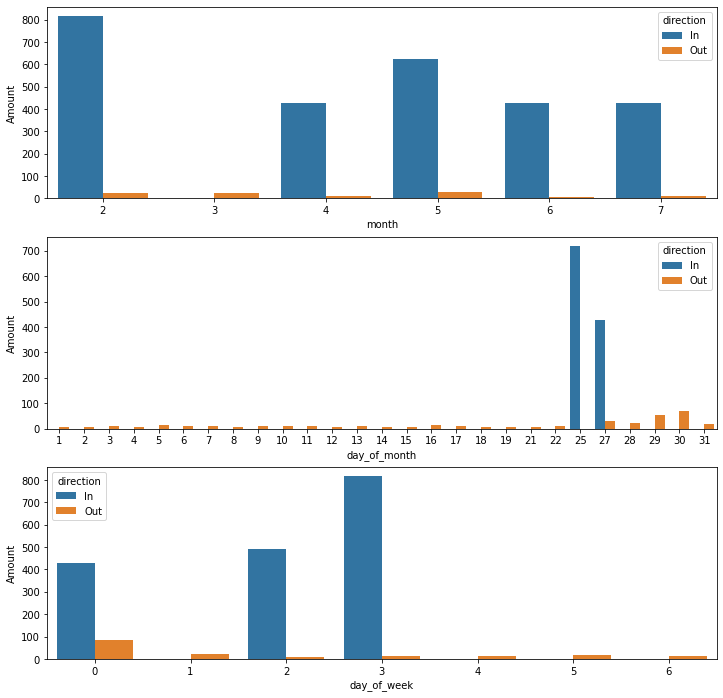

In [53]:
plot_monthly_inflows_outflows_user('918eb93c2d3b084614e3570886715f84')

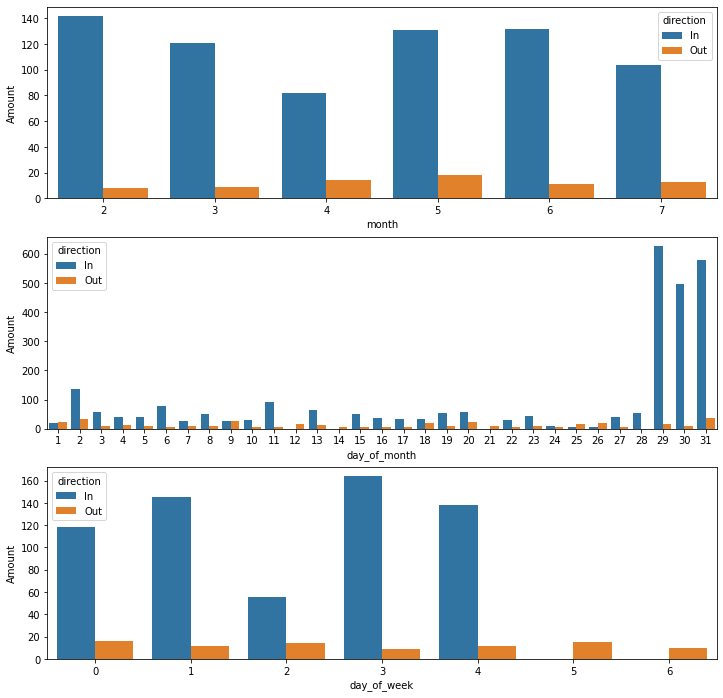

In [54]:
plot_monthly_inflows_outflows_user('bc639c7495889105713fc6b1025264ac')


**Top Transaction types**

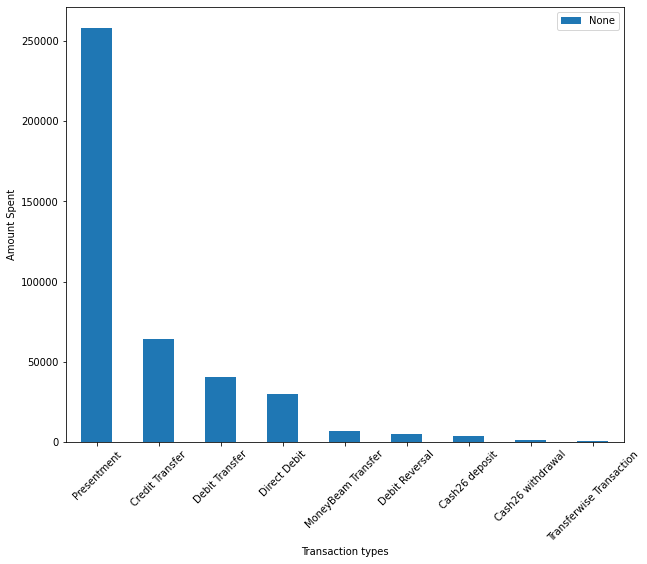

In [55]:
plt.figure(figsize=(10,8))
train.groupby('txn_explanations').size().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Transaction types')
plt.ylabel('Amount Spent')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.show()

**Top Categories**

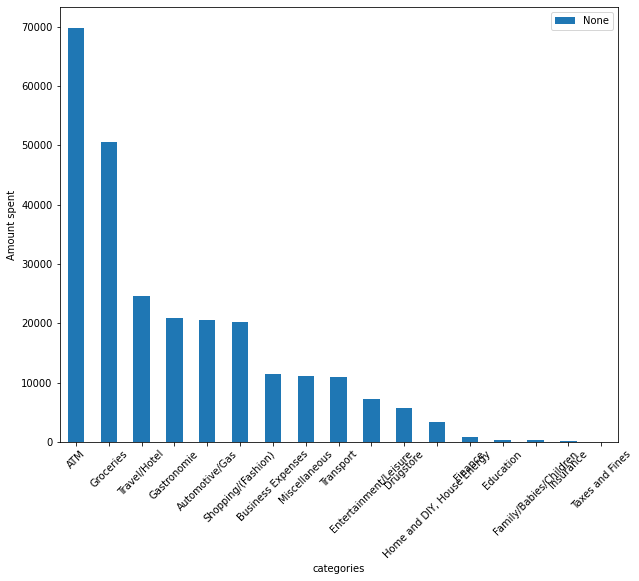

In [56]:
plt.figure(figsize=(10,8))
train.groupby('explanation').size().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('categories')
plt.ylabel('Amount spent')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.show()

In [57]:
def display_amount_for_month(value):    
    plt.figure(figsize=(10,8))
    tmp = train.query(f"month == {value}").groupby(['month','explanation'])['amount_n26_currency'].sum().sort_values(ascending=False).reset_index()
    sns.barplot(data=tmp, x='amount_n26_currency', y='explanation')
    plt.title(f'Amount spent for different categories for month {value}')
    plt.xlabel('Total Amount')
    plt.ylabel('Categories')

**Top categoreies for each month**

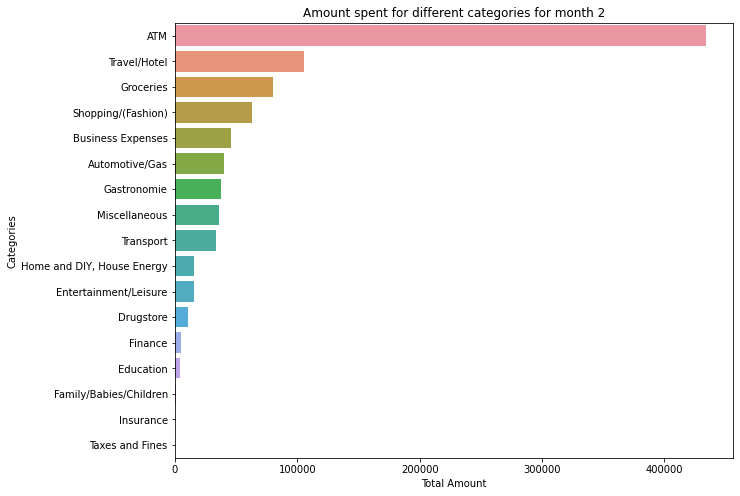

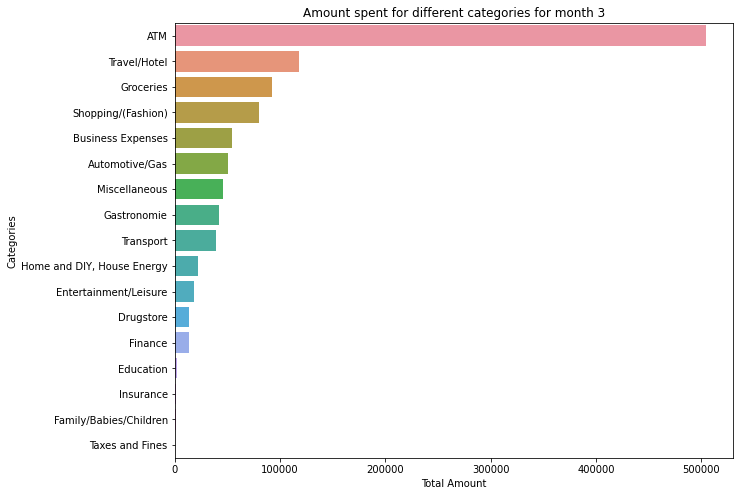

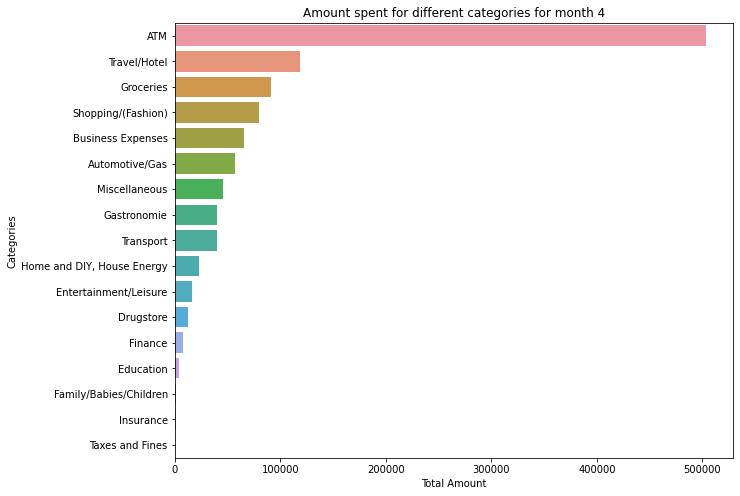

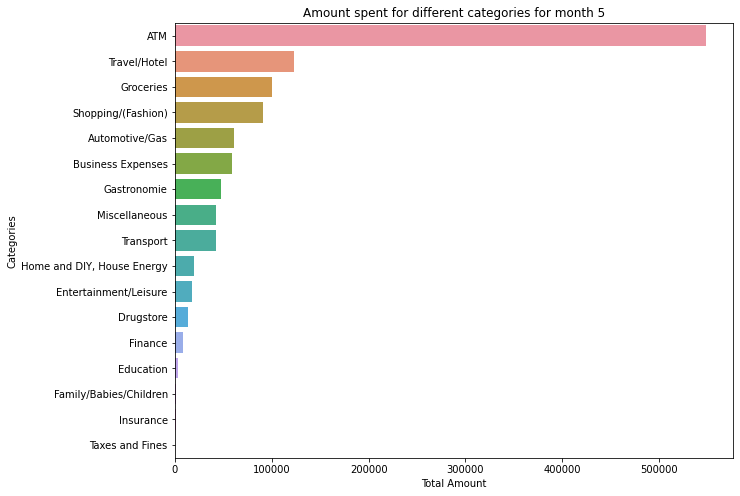

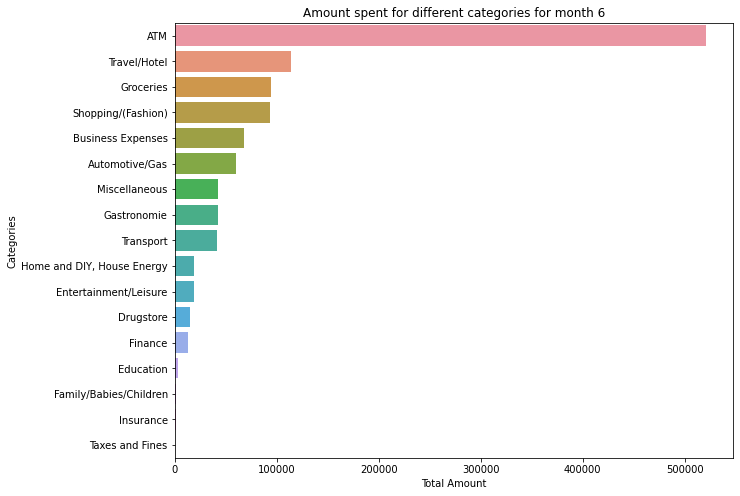

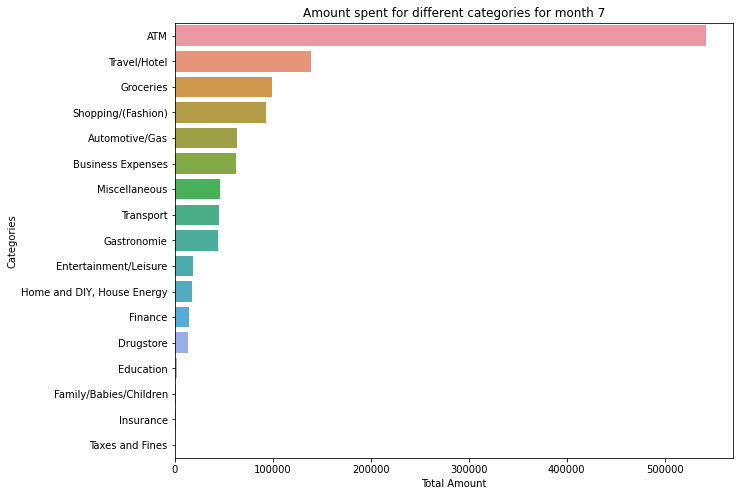

In [58]:
for i in range(2,8):
    display_amount_for_month(i)

**Observations**
- We can clearly see that top categories for all the months are;
  - ATM Cash withdrawl's
  - Followed byTravel, Groceries, Shopping
  - Same trend follows for almost every month

# Feature Engineering

**We will create a function which will aggregate on month and create features for amount**

In [59]:
def count_unique(series):
    return len(np.unique(series))

In [60]:
def create_direction_feature(data, direction):


    
    target_df = pd.DataFrame()

    create_feature_dict = {
        'amount_n26_currency': [np.sum, np.mean,np.min, np.max, np.median, np.var, np.std],
        'direction': [np.size],
        'txn_explanations': [count_unique]        
    }

    target_df = data.query(f"direction == '{direction}'").groupby(['user_id','month','day_of_month','day_of_week']).agg(create_feature_dict).reset_index()
    target_df.columns = ['user_id','month','day_of_month','day_of_week',f'{direction}_sum',f'{direction}_mean',f'{direction}_min',f'{direction}_max', f'{direction}_median',
    f'{direction}_var',f'{direction}_std','unique_txns',f'{direction}_count']
    return target_df

In [61]:
train_inflows = create_direction_feature(train,'In')

In [62]:
train_outflows = create_direction_feature(train,'Out')

In [63]:




with open(os.path.join('../models','user_id.pkl'),'rb') as output:
        le_dict_user = pickle.load(output)

        

train_inflows['user_id'] = train_inflows['user_id'].apply(lambda x: le_dict_user.get(x, 'NA'))
train_outflows['user_id'] = train_outflows['user_id'].apply(lambda x: le_dict_user.get(x, 'NA'))




train_inflows.to_csv('../input/private/train_income.csv')
train_outflows.to_csv('../input/private/train_outcome.csv')

In [64]:
train_inflows

,user_id,month,day_of_month,day_of_week,In_sum,In_mean,In_min,In_max,In_median,In_var,In_std,unique_txns,In_count
0,0,2,19,4,291,291.0,291,291,291.0,NaN,NaN,1,1
1,0,3,9,2,381,381.0,381,381,381.0,NaN,NaN,1,1
2,0,5,10,1,155,155.0,155,155,155.0,NaN,NaN,1,1
3,0,6,3,4,115,115.0,115,115,115.0,NaN,NaN,1,1
4,1,5,9,0,77,77.0,77,77,77.0,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64180,9999,7,4,0,194,194.0,194,194,194.0,NaN,NaN,1,1
64181,9999,7,5,1,11,11.0,11,11,11.0,NaN,NaN,1,1
64182,9999,7,8,4,583,583.0,583,583,583.0,NaN,NaN,1,1
64183,9999,7,21,3,583,583.0,583,583,583.0,NaN,NaN,1,1


In [65]:
train_outflows

,user_id,month,day_of_month,day_of_week,Out_sum,Out_mean,Out_min,Out_max,Out_median,Out_var,Out_std,unique_txns,Out_count
0,0,2,21,6,280,280.000000,280,280,280.0,NaN,NaN,1,1
1,0,3,1,1,11,11.000000,11,11,11.0,NaN,NaN,1,1
2,0,3,12,5,380,126.666667,15,346,19.0,36084.333333,189.958767,3,1
3,0,5,10,1,7,7.000000,7,7,7.0,NaN,NaN,1,1
4,0,5,12,3,147,147.000000,147,147,147.0,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231915,9999,7,16,5,19,6.333333,4,9,6.0,6.333333,2.516611,3,1
231916,9999,7,17,6,791,395.500000,58,733,395.5,227812.500000,477.297077,2,2
231917,9999,7,21,3,77,77.000000,77,77,77.0,NaN,NaN,1,1
231918,9999,7,24,6,44,44.000000,44,44,44.0,NaN,NaN,1,1


**Let's calculate the correlations to have a better view**

<AxesSubplot:>

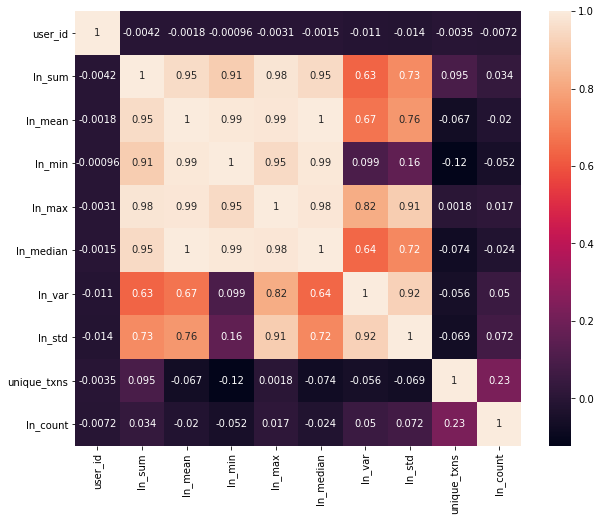

In [66]:
plt.figure(figsize=(10,8))
sns.heatmap(train_inflows.drop(['month','day_of_month','day_of_week'],axis=1).corr(), annot=True)

<AxesSubplot:>

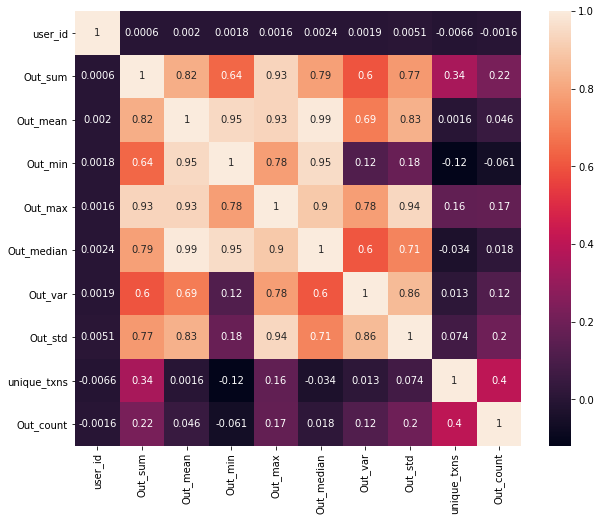

In [67]:
plt.figure(figsize=(10,8))
sns.heatmap(train_outflows.drop(['month','day_of_month','day_of_week'],axis=1).corr(), annot=True)

In [68]:
txn_category_amount = train.query("direction=='Out'").groupby(['user_id','month','explanation','day_of_week','day_of_month'])['amount_n26_currency'].\
    agg([np.sum, np.mean,np.min, np.max, np.median]).reset_index()

txn_categories = train.query("direction=='Out'").groupby(['user_id','month','day_of_week','day_of_month'])['explanation'].\
    value_counts().reset_index(name='count')

txn_categories = txn_categories.merge(txn_category_amount, on=['user_id','month','explanation',
    'day_of_week','day_of_month'],how='left')

txn_categories.rename(columns={'explanation':'categories','sum':'Total','amin':'min','amax':'max'},inplace=True)

In [69]:
txn_categories

,user_id,month,day_of_week,day_of_month,categories,count,Total,mean,min,max,median
0,000295594379774ab9ac2c78c946d615,2,6,21,ATM,1,280,280.000000,280,280,280.0
1,000295594379774ab9ac2c78c946d615,3,5,12,ATM,3,380,126.666667,15,346,19.0
2,000295594379774ab9ac2c78c946d615,5,3,12,ATM,1,147,147.000000,147,147,147.0
3,000295594379774ab9ac2c78c946d615,6,1,21,Entertainment/Leisure,1,7,7.000000,7,7,7.0
4,000295594379774ab9ac2c78c946d615,6,3,9,ATM,1,7,7.000000,7,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...
230798,fffde1ba10b4040deb651162f56c9fc4,7,5,16,Groceries,2,10,5.000000,4,6,5.0
230799,fffde1ba10b4040deb651162f56c9fc4,7,5,16,Business Expenses,1,9,9.000000,9,9,9.0
230800,fffde1ba10b4040deb651162f56c9fc4,7,6,10,ATM,1,77,77.000000,77,77,77.0
230801,fffde1ba10b4040deb651162f56c9fc4,7,6,17,ATM,1,58,58.000000,58,58,58.0
